## <center> Дипломный проект. 
## <center> «Модель прогнозирования стоимости жилья для агентства недвижимости»


###  Постановка задачи.

Разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

### Основные цели проекта:
1. Провести разведывательный анализ и очистку исходных данных. 
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.

Для начала давайте познакомимся с нашими данными:

In [38]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoost, cv, sum_models
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import json

In [39]:
#прочитаем наши данные
path = ('data.csv')
df = pd.read_csv(path)
print('Df shape: {}'.format(df.shape))
df.head(2)

Df shape: (377185, 18)


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"


In [40]:
# посмотрим на наши признаки
df.columns

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'],
      dtype='object')

Итак, у нас есть данные о 377185 объектах недвижимости. Каждый из них описывается следующими признаками:
1. 'status' — статус продажи;
2. 'private pool' и 'PrivatePool' — наличие собственного бассейна;
3. 'propertyType' — тип объекта недвижимости;
4. 'street' — адрес объекта;
5. 'baths' — количество ванных комнат;
6. 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
7. 'fireplace' — наличие камина;
8. 'city' — город;
9. 'schools' — сведения о школах в районе;
10. 'sqft' — площадь в футах;
11. 'zipcode' — почтовый индекс;
12. 'beds' — количество спален;
13. 'state' — штат;
14. 'stories' — количество этажей;
15. 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
16. 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

Проведём анализ структуры таблицы.

Посмотрим каками типами кодируются наши данные и сколько в них пропусков.

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Посмотрим уникальные и популярные значения в наших данных:

In [42]:
round(df.describe())

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


# Предобработка

## Предобработка фичи private_pool

Приведем значения данной фичи к числовому формату

In [43]:
df['private pool'].value_counts()

Yes    4181
Name: private pool, dtype: int64

In [44]:
#заполняем пропуски нулями
df['private pool'] = df['private pool'].fillna(0)

In [45]:
#значение yes переводим в числовое значение 1
df['private pool'] = df['private pool'].replace('Yes', 1)

In [46]:
df['private pool'].value_counts()

0    373004
1      4181
Name: private pool, dtype: int64

In [47]:
df['PrivatePool'].value_counts()

yes    28793
Yes    11518
Name: PrivatePool, dtype: int64

В данных встречается один и тот же столбец Private Pool. Вероятнее всего при составлении данных писали либо заносили опцию есть бассейн в столбец private pool,или Private Pool. Поэтому объединим данные в один столбец Private Pool. Другой же столбец удалим.

In [48]:
#заполняем пропуски нулями
df['PrivatePool'] = df['PrivatePool'].fillna(0)

# переводим значения Yes и yes в числовой формат 
df['PrivatePool'] = df['PrivatePool'].replace('Yes', 1)
df['PrivatePool'] = df['PrivatePool'].replace('yes', 1)
df['PrivatePool'].value_counts()

0    336874
1     40311
Name: PrivatePool, dtype: int64

In [49]:
# объединяем столбцы
df['PrivatePool'] = df['PrivatePool'] | df['private pool']
df['PrivatePool'].value_counts()

0    332693
1     44492
Name: PrivatePool, dtype: int64

In [50]:
# удаляем признак private poll
del df['private pool']

## Предобработка фичи beds

In [51]:
df['beds'].value_counts()[0:40].sum()/(df.shape[0]-df['beds'].isnull().sum())

0.9864884243956866

Топ 40 наименований по кроватям покрывают 98% всех данных. Поэтому сделаем предоработку только для них

In [52]:
df['beds'].value_counts()[40:].sum()

3863

In [53]:
df['beds'].value_counts()[0:40]

3 Beds     53459
4 Beds     35418
3          31406
2 Beds     26362
4          20030
2          16110
Baths      15282
3 bd       12877
5 Beds     11271
4 bd        8265
3.0         8088
5           6424
2 bd        5243
4.0         5231
1           4610
6 Beds      3810
5 bd        2633
2.0         2430
6           1806
5.0         1372
0           1230
7 Beds      1100
1 bd        1081
-- bd       1013
8 Beds       759
Bath         738
6 bd         656
7            511
             451
1.0          429
9 Beds       347
8            322
6.0          311
0.0          223
10 Beds      176
7 bd         147
12 Beds      130
8 bd          97
-- sqft       97
9             95
Name: beds, dtype: int64

Все что содержит в себе sqft, acre, Bath, -- не относится к beds, поэтому считаю эти данные nan

In [54]:
#все что содержит в себе sqft, acre, Bath считаем nan
df['beds'] = df['beds'].apply(
    lambda x: -9999 if str(x).find('acre') >= 0 else x
)
df['beds'] = df['beds'].apply(
    lambda x: -9999 if str(x).find('sqft') >= 0 else x
)
df['beds'] = df['beds'].apply(
    lambda x: -9999 if str(x).find('Baths') >= 0 else x
)
df['beds'] = df['beds'].apply(
    lambda x: -9999 if str(x).find('Bath') >= 0 else x
)
df['beds'] = df['beds'].apply(
    lambda x: -9999 if str(x).find('--') >= 0 else x
)

In [55]:
#заменим значение на int в признаке beds
d = {}
key = df['beds'].value_counts()[0:40].index.tolist()
key.remove(-9999)
key.remove(' ')
print(key)
values = [int(x[0]) for x in key]
d = dict(zip(key, values))

['3 Beds', '4 Beds', '3', '2 Beds', '4', '2', '3 bd', '5 Beds', '4 bd', '3.0', '5', '2 bd', '4.0', '1', '6 Beds', '5 bd', '2.0', '6', '5.0', '0', '7 Beds', '1 bd', '8 Beds', '6 bd', '7', '1.0', '9 Beds', '8', '6.0', '0.0', '10 Beds', '7 bd', '12 Beds', '8 bd', '9', '11 Beds', '7.0', '10']


In [56]:
#заменим значение на int в признаке beds
d['10 Beds'] = 10
d['11 Beds'] = 11
d['12 Beds'] = 12

In [57]:
df['beds'] = df['beds'].apply(lambda x: d[x] if x in d else -9999)

In [58]:
df['beds'].value_counts()[0:20]

-9999    112508
 3       105830
 4        68944
 2        50145
 5        21700
 6         6583
 1         6186
 7         1825
 0         1453
 8         1178
 9          442
 10         176
 12         130
 11          85
Name: beds, dtype: int64

## Предобработка фичи schools

In [59]:
# сделаем десереализацию schools
json.loads(df['schools'].iloc[3][1:-1].replace("'", '"')).items()

dict_items([('rating', ['9/10', '9/10', '10/10', '9/10']), ('data', {'Distance': ['1.05mi', '0.1mi', '1.05mi', '0.81mi'], 'Grades': ['5-6', 'PK-4', '7-8', '9-12']}), ('name', ['Mcculloch Intermediate School', 'Bradfield Elementary School', 'Highland Park Middle School', 'Highland Park High School'])])

In [60]:
num_schools = []
for i in tqdm(range(0, df.shape[0])):
    try:
        cur = json.loads(df['schools'].iloc[i][1:-1].replace("'", '"')).items()
        for key,value in cur:
            if key == 'rating':
                num_schools.append(len(value))
    except ValueError:
        num_schools.append(-9999)

100%|██████████| 377185/377185 [00:14<00:00, 25981.71it/s]


In [61]:
# создадим новый признак num_schools
df['num_schools'] = num_schools

In [62]:
df['num_schools'].value_counts()

 3       205432
 8        37768
 2        35414
 5        28849
 4        20511
 6        11429
-9999     11275
 1         8706
 7         6534
 0         4204
 24        2066
 22        1786
 63         778
 10         772
 11         756
 9          532
 12         150
 61         129
 14          43
 15          33
 26          10
 13           8
Name: num_schools, dtype: int64

In [63]:
# удалим признак schools
del df['schools']

## Предобработка homeFacts

Распарсим json через парсинг.

Мы видим, что нам нужно создать 7 дополнительных признаков:Year Build, Remodeled year, Heating, Cooling, Parking, lotsize, Price/sqft.


In [64]:
df['homeFacts'].iloc[3]

"{'atAGlanceFacts': [{'factValue': '2006', 'factLabel': 'Year built'}, {'factValue': '2006', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': 'Detached Garage', 'factLabel': 'Parking'}, {'factValue': '8,220 sqft', 'factLabel': 'lotsize'}, {'factValue': '$371/sqft', 'factLabel': 'Price/sqft'}]}"

In [65]:
# создаем признаки Year Build, Remodeled year, Heating, Cooling, Parking, lotsize, Price/sqft.
df['Year built'] = 0
df['Remodeled year'] = 0
df['Heating'] = 0
df['Cooling'] = 0
df['Parking'] = 0
df['lotsize'] = 0
df['Price/sqft'] = 0

In [66]:
# распарсим homeFacts через парсинг
Year_build = []
Remodeled_year = []
Heating = []
Cooling = []
Parking = []
lotsize = []
Price_sqft = []
for i in tqdm(range(0, df.shape[0])):
    parse = [el.split(': ')[1].replace(", 'factLabel'", '')[1:-1] for el in df['homeFacts'].iloc[i].split('factValue')[1:] ]
    Year_build.append(parse[0])
    Remodeled_year.append(parse[1])
    Heating.append(parse[2])
    Cooling.append(parse[3])
    Parking.append(parse[4])
    lotsize.append(parse[5])
    Price_sqft.append(parse[6])

 10%|▉         | 36171/377185 [00:00<00:08, 39616.76it/s]

100%|██████████| 377185/377185 [00:11<00:00, 33409.88it/s]


In [67]:
# заполняем наши новые признаки полученными данными
df['Year built'] = Year_build
df['Remodeled year'] = Remodeled_year
df['Heating'] = Heating
df['Cooling'] = Cooling
df['Parking'] = Parking
df['lotsize'] = lotsize
df['Price/sqft'] = Price_sqft

In [68]:
df.head(3)

,status,propertyType,street,baths,homeFacts,fireplace,city,sqft,zipcode,beds,...,MlsId,target,num_schools,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,2900,28387,4,...,611019,"$418,000",-9999,2019,,"Central A/C, Heat Pump",,,on,$144
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"1,947 sqft",99216,3,...,201916904,"$310,000",3,2019,,,,,5828 sqft,$159/sqft
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"3,000 sqft",90049,3,...,FR19221027,"$2,895,000",3,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft


In [69]:
# удаляем признак homeFacts
del df['homeFacts']

## Предобработка года постройки и когда был ремоделлинг

In [70]:
# обработаем признак Year built
df['Year built'] = df['Year built'].replace(r'^\s*$', np.nan, regex=True)
df['Year built'] = df['Year built'].replace(r'on', np.nan, regex=True)

In [71]:
# обработаем признак Remodeled year
df['Remodeled year'] = df['Remodeled year'].replace(r'on', np.nan, regex=True)
df['Remodeled year'] = df['Remodeled year'].replace(r'^\s*$', np.nan, regex=True)

In [72]:
#сгруппируем данные по годам и посчитаем сколько было построено домов в каждом году
grouped = df.groupby('Year built', as_index=False).agg(count=('Year built', 'count'))
grouped=grouped.sort_values(by='count', ascending=False)

# построим график отражающий сколько было построено домов в каждом году
import plotly.express as px
fig = px.bar(
    data_frame=grouped, #датафрейм
    x='Year built', #ось x
    y='count', #ось y
    color='Year built', #расцветка в зависимости от страны
    text = 'count', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Количество домов построенных в каждом году' #заголовок
)
#отображаем его
fig.show()
fig.write_html('plotly/bar_1.html')

Больше всего домов построено в 2019 году.

In [73]:
#сгруппируем данные по годам и посчитаем сколько было отремонтировано домов в каждом году
grouped = df.groupby('Remodeled year', as_index=False).agg(count=('Remodeled year', 'count'))
grouped=grouped.sort_values(by='count', ascending=False)

# построим график отражающий сколько было отремонтировано домов в каждом году
import plotly.express as px
fig = px.bar(
    data_frame=grouped, #датафрейм
    x='Remodeled year', #ось x
    y='count', #ось y
    color='Remodeled year', #расцветка в зависимости от страны
    text = 'count', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Количество отремонтированных домов  в каждом году' #заголовок
)
#отображаем его
fig.show()
fig.write_html('plotly/bar_2.html')

Большинство ремонтов было с 2002 по 2008 года.

In [74]:
df['Year built'] = df['Year built'].apply(
            lambda x: int(x) if str(x).isdigit() else np.nan
)


In [75]:
df['Year built'].iloc[0]

2019.0

In [76]:
df['Year built'].max()

559990649990.0

Максимальное значение большое, давайте посмотрим сколько таких.

In [77]:
df[df['Year built'] > 2023]

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,MlsId,target,num_schools,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
77801,Active,Condo/Townhome/Row Home/Co-Op,12522 15th Ave NE,2.5,NaN,Seattle,"1,486",98125,3,WA,...,161732709,"$649,990",8,5.599906e+11,NaN,,,,on,$437
164166,Active,"Traditional, Transitional",2421 Flume Gate Ct,NaN,1,Raleigh,"3,518",27603,-9999,NC,...,2226990,"534,000",3,2.025000e+03,NaN,,,,—,$152 / Sq. Ft.
313508,Active,Traditional,2405 Flume Gate Ct,NaN,1,Raleigh,"3,000",27603,-9999,NC,...,2226994,"494,990",3,2.025000e+03,NaN,,,,0.77 Acres,$165 / Sq. Ft.
354143,Active,Condo/Townhome/Row Home/Co-Op,12522 15th Ave NE,2.5,NaN,Seattle,"1,233",98125,3,WA,...,161732708,"$559,990",8,5.599906e+11,NaN,,,,on,$454


In [78]:
df[df['Year built'] < 1800]

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,MlsId,target,num_schools,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
2064,For sale,Single Family,2504 Main St,Bathrooms: 10,NaN,Barnstable,"Total interior livable area: 7,366 sqft",2630,-9999,MA,...,NaN,"$1,425,000",3,1740.0,2016,Forced air,"Other, Wall",4 spaces,3.25 acres lot,$193
2410,for sale,lot/land,12517 SE Petrovitsky Rd,NaN,NaN,Renton,"3,380 sqft",98058,-9999,WA,...,1512534,"$249,000",3,1700.0,NaN,Other,,Attached Garage,0.92 acres,$74/sqft
23118,foreclosure,single-family home,1810 Lincoln St,2 Baths,NaN,Laredo,"2,348 sqft",78040,3,TX,...,NaN,"$89,714",0,1799.0,NaN,,,,"6,172 sqft",$38/sqft
50661,Active Under Contract,Condo/Townhome/Row Home/Co-Op,1307 35th St NW,3,NaN,Washington,2145,20007,2,DC,...,DCDC445998,"$1,695,000",8,1794.0,NaN,Radiator,Central A/C,"Driveway, Off Street",4299,$790
54270,Active,Single Family Home,125 Main St,3.5,NaN,Vergennes,3867,05491,3,VT,...,4745585,"$568,000",4,1795.0,NaN,"Baseboard, Hot Water, Multi Zone, Stove - Gas",,Garage Type,13068,$147
66331,Active,Land,934 Ranch Rd # 7150G,NaN,NaN,Laredo,0,78046,-9999,TX,...,20192989,"$290,000",6,1799.0,NaN,,,,435600,on
81327,For sale,Townhouse,424 Pine St,6,Yes,Philadelphia,"4,900 sqft",19106,4,PA,...,PAPH812888,"$2,095,000",2,1796.0,NaN,Other,Central,Carport,"2,613 sqft",$428
90721,P Pending Sale,Single Family Home,105 Nulls Rd,2,# Fireplaces - Woodburning,Little Falls,2378,13365,4,NY,...,S1217473,"$149,900",4,1795.0,NaN,Oil,,,217800,$63
120342,for sale,lot/land,W Trinity Ln,NaN,NaN,Nashville,1 sqft,37207,-9999,TN,...,1997063,"$5,950,000",3,1.0,1111,,,,12.59 acres,"$5,950,000/sqft"
129990,Closed,Federal,1232 30th St NW,NaN,NaN,Washington,"1,755",20007,-9999,DC,...,DCDC448420,NaN,3,1780.0,1994,,,,"2,032 Sq. Ft.",$1365 / Sq. Ft.


Видно, что в 2025 году есть пару объектов, но они кажется строятся. Их исключать не буду. Исключу только с e+11.
Исключу те, у которых год постройки раньше  1700 года.

In [79]:
#исключаем год постройки позже 2025
df.loc[(df['Year built'] >  2025)
       & (df['Year built'].notna()), 'Year built'] = np.nan

In [80]:
#исключаем год постройки раньше 1700
df.loc[(df['Year built'] <  1700)
       & (df['Year built'].notna()), 'Year built'] = np.nan

In [81]:
#посмотрим на минимальный год постройки
df['Year built'].min()

1700.0

In [82]:
#убираем года раньше 1700 года в признаке Remodeled year
df['Remodeled year'] = df['Remodeled year'].apply(
            lambda x: int(x) if str(x).isdigit() else np.nan
)
df.loc[(df['Remodeled year'] <  1700)
       & (df['Remodeled year'].notna()), 'Remodeled year'] = np.nan

## Предобработка cooling

In [83]:
# смотрим сколько всего уникальных значений в признаке Cooling
df['Cooling'].value_counts()[0:30].sum()

361512

In [84]:
# смотрим количество строк и столбцов
df.shape

(377185, 23)

In [85]:
361512/377185

0.9584474462133966

In [86]:
# посмотрим уникальные значения
df['Cooling'].value_counts()[0:30]

Central                                            158754
                                                   120434
Central Air                                         14384
No Data                                             10616
Has Cooling                                          9730
None                                                 7390
Central Electric                                     6154
Wall                                                 4018
Central Gas                                          3573
on                                                   3533
Central Heating                                      2807
Cooling System                                       2700
Central A/C                                          2051
Other                                                1840
Central A/C (Electric), Central Heat (Gas)           1646
Central A/C (Electric), Central Heat (Electric)      1429
Refrigeration                                        1075
Central, Elect

Так как central air это подмножество air, то уберу эту фичу. Плюс heating дает такие же значение по смыслу как и cooling.

In [87]:
# удаляем признак Cooling
del df['Cooling']

## Предобработка heating

 Выделю категории  Forced air/Electric/Gas/Heat Pump/Central air

In [88]:
# смотрим уникальные значения признака Heating
df['Heating'].value_counts()[0:20]

                         105799
Forced Air                82807
Forced air                51506
Other                     29623
Electric                  10211
Gas                        9296
No Data                    8611
Central Air                7814
Central Electric           7112
Central                    6247
Heat Pump                  6104
Central, Electric          4253
Baseboard                  3815
on                         3533
Wall                       3301
Electric Heat              3064
Heat pump                  2747
Heating System             2709
Forced air, Heat pump      1727
Radiant                    1485
Name: Heating, dtype: int64

Буду рассматривать такие категории как Forced air/electric/gas/central/pump

In [89]:
# рассмотрим такие категории как Forced air/electric/gas/central/pump
df['Heating'] = df['Heating'].replace(r'', np.nan, regex=True)
df['Heating'] = df['Heating'].replace(r'Air', 'air', regex=True)
df['Heating'] = df['Heating'].replace(r'Pump', 'pump', regex=True)
df['Heating'] = df['Heating'].apply(
        lambda x: 'electric' if str(x).find('lectric') >= 0 else x
)
df['Heating'] = df['Heating'].apply(
        lambda x: 'Gas' if str(x).find('as') >= 0 else x
)
df['Heating'] = df['Heating'].apply(
        lambda x: 'pump' if str(x).find('pump') >= 0 else x
)
df['Heating'] = df['Heating'].apply(
        lambda x: 'Central' if str(x).find('entral') >= 0 else x
)
df.loc[(df['Heating'] != 'Forced air') & (df['Heating'] != 'electric') & 
   (df['Heating'] != 'Gas') & (df['Heating'] != 'Central') & (df['Heating'] != 'pump')
       & (df['Heating'].notna()), 'Heating']  = 'Other'

##  Предобработка Parking

In [90]:
#смотрим сколько процентов покрывают первые 10 значений
df['Parking'].value_counts()[0:8].sum()/df.shape[0]

0.8588782692843034

Так как 10 первые значений покрывают 85% всех значений фичи, то оставлю первые 10 категорий уникальными, а остальные сделаю  категорией Others (другая, она будет отличаться от того что нет данных в лучшую сторону)

In [91]:
df['Parking'].value_counts()[0:8]

                   171887
Attached Garage     70752
2 spaces            28063
1 space             14252
No Data             13334
Detached Garage     13201
Carport              7743
3 spaces             4724
Name: Parking, dtype: int64

In [92]:
df['Parking'] = df['Parking'].replace(r'^\s*$', np.nan, regex=True)
df['Parking'] = df['Parking'].replace(r'No Data', np.nan, regex=True)
df['Parking'] = df['Parking'].replace(r'on', np.nan, regex=True)

In [93]:
df['Parking'].value_counts()[0:10]

Attached Garage             70752
2 spaces                    28063
1 space                     14252
Detached Garage             13201
Carport                      7743
3 spaces                     4724
Off Street                   3622
Carport, Attached Garage     3025
1                            2936
4 spaces                     2917
Name: Parking, dtype: int64

In [94]:
# Оставлю самые популярные значения данной фичи. Остальные сделаю категорией other.
df['Parking'] = df['Parking'].apply(
lambda x: 'Attached Garage' if str(x).find('ttached') >= 0 else x
)
df['Parking'] = df['Parking'].apply(
        lambda x: 'Detached Garage' if str(x).find('etached') >= 0 else x
)
df['Parking'] = df['Parking'].apply(
        lambda x: '2 spaces' if str(x).find('2') >= 0 else x
)
df['Parking'] = df['Parking'].apply(
        lambda x: '1 space' if str(x).find('1') >= 0 else x
)
df['Parking'] = df['Parking'].apply(
        lambda x: '3 spaces' if str(x).find('3') >= 0 else x
)
df['Parking'] = df['Parking'].apply(
        lambda x: 'Off street' if str(x).find('Off') >= 0 else x
)

In [95]:
df.loc[(df['Parking'] != 'Attached Garage') & (df['Parking'] != '2 spaces') & 
   (df['Parking'] != '1 space') & (df['Parking'] != 'Detached Garage') & (df['Parking'] != 'Carport') &
  (df['Parking'] != 'Off street') & (df['Parking'].notna()), 'Parking']  = 'Other'

## Предобработка lotsize

In [96]:
# посмотрим первые 40 уникальных значений
df['lotsize'].value_counts()[0:40]

               33067
on             28388
—              25251
No Data         5330
-- sqft lot     3819
0.26 acres      2511
0.25 acres      2339
0.28 acres      2098
0.27 acres      1944
0.29 acres      1919
0.34 acres      1608
6,098 sqft      1525
0.3 acres       1439
7,405 sqft      1357
0.31 acres      1338
6,534 sqft      1292
0.32 acres      1272
4,356 sqft      1270
10,000 sqft     1260
5,227 sqft      1175
5,000 sqft      1117
0.33 acres      1109
0.35 acres      1106
8,712 sqft      1030
0.46 acres      1020
3,920 sqft       993
0.36 acres       983
8,276 sqft       976
0.37 acres       952
0.5 acres        862
10019            858
10,019 sqft      845
10000            834
0.38 acres       797
0.39 acres       788
1 acre           777
4,792 sqft       758
9,583 sqft       747
0.4 acres        746
0.41 acres       732
Name: lotsize, dtype: int64

В данных встречается sqft и acres. 

In [97]:
# переведем sqft в acres преобразованием sqft/43650.
def lotsize(example):
    
    example['lotsize'] = example['lotsize'].replace(r'^\s*$', np.nan, regex=True)
    example['lotsize'] = example['lotsize'].replace(r'on', np.nan, regex=True)
    example['lotsize'] = example['lotsize'].replace(r'—', np.nan, regex=True)
    example['lotsize'] = example['lotsize'].replace(r'No Data', np.nan, regex=True)
    example['lotsize'] = example['lotsize'].replace(r'-- sqft lot', np.nan, regex=True)
    
    example['lotsize'] = example['lotsize'].replace(r',', '', regex=True)
    example['lotsize'] = example['lotsize'].apply(
        lambda x: str(round(int(x.split(" ")[0])/43560, 2)) + " acres" if str(x).find('sqft') >= 0 else x
    )

    example['lotsize'] = example['lotsize'].replace(r'Acres', 'acres', regex=True)
    example['lotsize'] = example['lotsize'].replace(r'acres lot', 'acres', regex=True)
    example['lotsize'] = example['lotsize'].apply(
            lambda x: str(round(int(x.split(" ")[0])/43560, 2)) + " acres" if str(x).find('q.') >= 0 else x
    )
    example['lotsize'] = example['lotsize'].apply(
            lambda x: str(round(int(x)/43560, 2)) + " acres" if str(x).isdigit() else x
    )
    example['lotsize'] = example['lotsize'].apply(
            lambda x: float(x.split(" ")[0]) if str(x).find('cre') >= 0 else np.nan
    )
    return example

In [98]:
df = lotsize(df)

<AxesSubplot: >

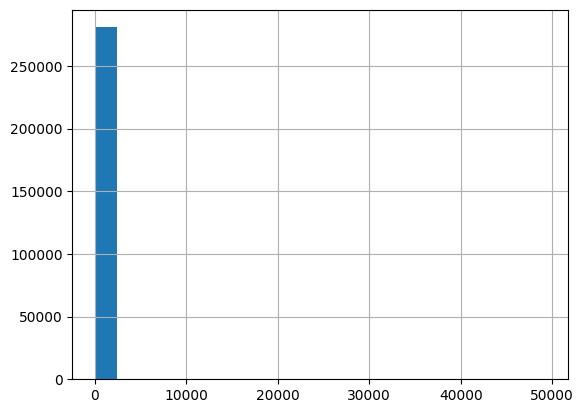

In [99]:
# построим гистограмму и посмотрим на выбросы
df['lotsize'][df['lotsize'].notna()].hist(bins = 20)

Из графика видно, что присутствуют выбросы. Удалим их.

In [100]:
data_lotsize = df['lotsize'][df['lotsize'].notna()]

In [101]:
quant_095 = np.quantile(df['lotsize'][df['lotsize'].notna()], 0.95)

<AxesSubplot: >

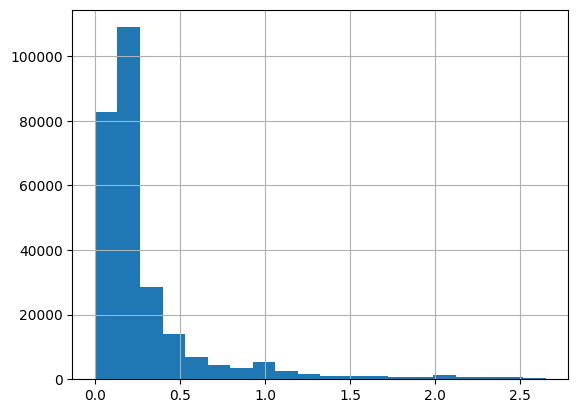

In [102]:
# построим еще раз гистограмму 
data_lotsize[data_lotsize < quant_095].hist(bins=20)

Видно что картина распределения стала адекватной.

In [103]:
df['lotsize'] = df['lotsize'].apply(
    lambda x: x if x < quant_095  else np.nan
)

In [104]:
df

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,PrivatePool,MlsId,target,num_schools,Year built,Remodeled year,Heating,Parking,lotsize,Price/sqft
0,Active,Single Family Home,240 Heather Ln,3.5,Gas Logs,Southern Pines,2900,28387,4,NC,...,0,611019,"$418,000",-9999,2019.0,NaN,pump,NaN,NaN,$144
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,NaN,Spokane Valley,"1,947 sqft",99216,3,WA,...,0,201916904,"$310,000",3,2019.0,NaN,NaN,NaN,0.13,$159/sqft
2,for sale,single-family home,2005 Westridge Rd,2 Baths,yes,Los Angeles,"3,000 sqft",90049,3,CA,...,1,FR19221027,"$2,895,000",3,1961.0,1967.0,Forced air,Attached Garage,0.20,$965/sqft
3,for sale,single-family home,4311 Livingston Ave,8 Baths,yes,Dallas,"6,457 sqft",75205,5,TX,...,0,14191809,"$2,395,000",4,2006.0,2006.0,Forced air,Detached Garage,0.19,$371/sqft
4,for sale,lot/land,1524 Kiscoe St,NaN,NaN,Palm Bay,NaN,32908,-9999,FL,...,0,861745,"$5,000",3,NaN,NaN,NaN,NaN,0.23,on
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,NaN,Single Family,20800 NE 23rd Ave,6.0,NaN,Miami,"4,017",33180,5,FL,...,1,A10702700,"$1,249,000",2,1990.0,1990.0,Other,2 spaces,0.20,$311
377181,for sale,condo,3530 N Lake Shore Dr #4B,3 Baths,NaN,Chicago,"2,000 sqft",60657,3,IL,...,0,10374233,"$674,999",3,1924.0,NaN,Other,NaN,NaN,$337/sqft
377182,for sale,single-family home,15509 Linden Blvd,3 Baths,NaN,Jamaica,"1,152 sqft",11434,3,NY,...,0,NaN,"$528,000",2,1950.0,1950.0,Other,2 spaces,0.04,$458/sqft
377183,NaN,NaN,7810 Pereida St,NaN,NaN,Houston,NaN,77028,-9999,TX,...,0,NaN,"$34,500",3,NaN,NaN,Other,NaN,NaN,on


## Предобработка Price/sqft

In [105]:
# обработаем признак Price/sqft
df['Price/sqft'] = df['Price/sqft'].replace(r'', np.nan, regex=True)
df['Price/sqft'] = df['Price/sqft'].replace(r'on', np.nan, regex=True)
df['Price/sqft'] = df['Price/sqft'].replace(r'No', np.nan, regex=True)

df['Price/sqft'] = df['Price/sqft'].replace("$", "", regex=True)
df['Price/sqft'] = df['Price/sqft'].replace(r'/sqft', "", regex=True)

df['Price/sqft'] = df['Price/sqft'].replace(r' / Sq. Ft.', "", regex=True)
df['Price/sqft'] = df['Price/sqft'].replace(r',', "", regex=True)
df['Price/sqft'] = df['Price/sqft'].apply(
        lambda x: x[1:] if str(x).find('$') >= 0 else x
)

In [106]:
data_price_sqft = df['Price/sqft'][df['Price/sqft'].notna()]

In [107]:
data_price_sqft = data_price_sqft.astype('int')

<AxesSubplot: >

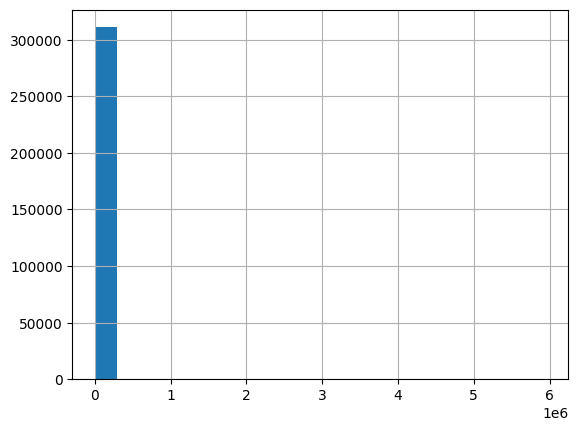

In [108]:
# построим гистограмму и посмотрим распределение
data_price_sqft.hist(bins = 20)

Из графика видно, что присутствуют выбросы. Удалим их.

In [109]:
quant_095 = np.quantile(data_price_sqft , 0.95)

In [110]:
quant_095

738.0

<AxesSubplot: >

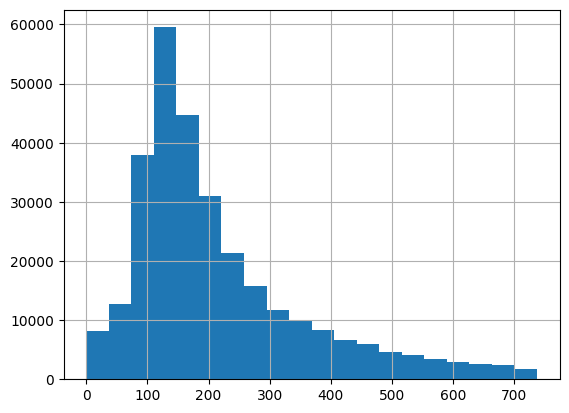

In [111]:
# построим еще раз гистограмму и посмотрим распределение
data_price_sqft[data_price_sqft < quant_095].hist(bins=20)

In [112]:
df['Price/sqft'] = df['Price/sqft'].apply(
        lambda x: int(x) if str(x).isdigit() == True else x
)
df['Price/sqft'] = df['Price/sqft'].apply(
    lambda x: x if x < quant_095  else np.nan
)

## Остальная предобработка фичей 

In [113]:
df.head(5)

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,PrivatePool,MlsId,target,num_schools,Year built,Remodeled year,Heating,Parking,lotsize,Price/sqft
0,Active,Single Family Home,240 Heather Ln,3.5,Gas Logs,Southern Pines,2900,28387,4,NC,...,0,611019,"$418,000",-9999,2019.0,NaN,pump,NaN,NaN,144.0
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,NaN,Spokane Valley,"1,947 sqft",99216,3,WA,...,0,201916904,"$310,000",3,2019.0,NaN,NaN,NaN,0.13,159.0
2,for sale,single-family home,2005 Westridge Rd,2 Baths,yes,Los Angeles,"3,000 sqft",90049,3,CA,...,1,FR19221027,"$2,895,000",3,1961.0,1967.0,Forced air,Attached Garage,0.20,NaN
3,for sale,single-family home,4311 Livingston Ave,8 Baths,yes,Dallas,"6,457 sqft",75205,5,TX,...,0,14191809,"$2,395,000",4,2006.0,2006.0,Forced air,Detached Garage,0.19,371.0
4,for sale,lot/land,1524 Kiscoe St,NaN,NaN,Palm Bay,NaN,32908,-9999,FL,...,0,861745,"$5,000",3,NaN,NaN,NaN,NaN,0.23,NaN


In [114]:
df['MlsId'].value_counts()

NO MLS                     24
No MLS #                   16
 A, Houston, TX 77008      13
 12A, Orlando, FL 32833    11
 B, Houston, TX 77008       9
                           ..
19092240                    1
RX-10563061                 1
218080001                   1
14154778                    1
10374233                    1
Name: MlsId, Length: 232944, dtype: int64

Много уникальных значений в этой фиче. Плюс похоже что это айдишник, поэтому удаляю. Аналогично с фичей mls-id

In [115]:
del df['MlsId']
del df['mls-id']

Аналогично с zipcode.

In [116]:
df['zipcode'].value_counts()

32137         2141
33131         1563
34747         1488
78245         1390
34759         1333
              ... 
27613-4237       1
43054            1
41630            1
27615-3709       1
64015            1
Name: zipcode, Length: 4549, dtype: int64

In [117]:
del df['zipcode']

In [118]:
df['city'].value_counts()

Houston            24442
San Antonio        15592
Miami              15524
Jacksonville       10015
Dallas              8856
                   ...  
New Albany             1
Los Altos Hills        1
Lake worth             1
Lisle                  1
Blue Springs           1
Name: city, Length: 2026, dtype: int64

Очень много категорий у улицы. Удаляю.

In [119]:
df['street'].value_counts()[0:10]

Address Not Disclosed    672
Undisclosed Address      517
(undisclosed Address)    391
Address Not Available    175
Unknown Address           72
2103 E State Hwy 21       57
11305 Gulf Fwy            54
17030 Youngblood Rd.      38
NE 58th Cir               34
9470 Lancaster Rd. SW     32
Name: street, dtype: int64

In [120]:
del df['street']

In [121]:
df.head(4)

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,PrivatePool,target,num_schools,Year built,Remodeled year,Heating,Parking,lotsize,Price/sqft
0,Active,Single Family Home,3.5,Gas Logs,Southern Pines,2900,4,NC,NaN,0,"$418,000",-9999,2019.0,NaN,pump,NaN,NaN,144.0
1,for sale,single-family home,3 Baths,NaN,Spokane Valley,"1,947 sqft",3,WA,2.0,0,"$310,000",3,2019.0,NaN,NaN,NaN,0.13,159.0
2,for sale,single-family home,2 Baths,yes,Los Angeles,"3,000 sqft",3,CA,1.0,1,"$2,895,000",3,1961.0,1967.0,Forced air,Attached Garage,0.20,NaN
3,for sale,single-family home,8 Baths,yes,Dallas,"6,457 sqft",5,TX,3.0,0,"$2,395,000",4,2006.0,2006.0,Forced air,Detached Garage,0.19,371.0


## Фича stories

In [122]:
df['stories'].value_counts()[0:40]

1.0                    67454
2.0                    55283
1                      23086
2                      18146
3.0                    11275
0.0                     7241
One                     5758
0                       4273
3                       4228
9.0                     2918
2.00                    2777
Two                     2495
4.0                     2137
2 Story                 1970
1 Story                 1253
1.00                    1202
4                        892
3+                       868
6.0                      718
1.50                     650
5.0                      616
Three Or More            569
3.00                     517
9                        468
One Story                395
Lot                      365
Townhouse                325
7.0                      312
Ranch/1 Story            293
6                        283
Multi/Split              271
8.0                      255
Two Story or More        253
2 Stories                235
1.5           

Как видно из частотности будем рассматривать 0/1/2/3/4/5/6 stories

In [123]:
# обработаем 1 stories
df['stories'] = df['stories'].apply(
lambda x: int(1) if str(x).find('1') >= 0 else x
)

In [124]:
# обработаем 2 stories
df['stories'] = df['stories'].apply(
lambda x: int(2) if str(x).find('2') >= 0 else x
)

In [125]:
# обработаем 4 stories
df['stories'] = df['stories'].apply(
lambda x: int(4) if str(x).find('4') >= 0 else x
)

In [126]:
# обработаем 3 stories
df['stories'] = df['stories'].apply(
lambda x: int(3) if str(x).find('3') >= 0 else x
)

In [127]:
# обработаем остальные значения
df['stories'] = df['stories'].apply(
lambda x: int(1) if str(x).find('ne') >= 0 else x
)

In [128]:
df['stories'] = df['stories'].apply(
lambda x: int(5) if str(x).find('5') >= 0 else x
)
df['stories'] = df['stories'].apply(
lambda x: int(6) if str(x).find('6') >= 0 else x
)
df['stories'] = df['stories'].apply(
lambda x: int(2) if str(x).find('wo') >= 0 else x
)
df['stories'] = df['stories'].apply(
lambda x: int(0) if str(x).find('0.0') >= 0 else x
)
df['stories'] = df['stories'].apply(
lambda x: int(0) if str(x).find('0') >= 0 and str(x) == '0' else x
)

In [129]:
# остальные сделаем -9999
df.loc[(df['stories'] != 0) & (df['stories'] != 1) & 
   (df['stories'] != 2) & (df['stories'] != 3) & (df['stories'] != 4) &
  (df['stories'] != 5) & (df['stories'] != 6) & (df['stories'] != 7) & (df['stories'].notna()), 'stories']  = -9999

In [130]:
# смотрим результат
df['stories'].value_counts()

 1       102657
 2        82638
 3        17367
 0        11531
-9999      7117
 4         3281
 6         1039
 5          840
Name: stories, dtype: int64

In [131]:
df.head(3)

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,PrivatePool,target,num_schools,Year built,Remodeled year,Heating,Parking,lotsize,Price/sqft
0,Active,Single Family Home,3.5,Gas Logs,Southern Pines,2900,4,NC,NaN,0,"$418,000",-9999,2019.0,NaN,pump,NaN,NaN,144.0
1,for sale,single-family home,3 Baths,NaN,Spokane Valley,"1,947 sqft",3,WA,2,0,"$310,000",3,2019.0,NaN,NaN,NaN,0.13,159.0
2,for sale,single-family home,2 Baths,yes,Los Angeles,"3,000 sqft",3,CA,1,1,"$2,895,000",3,1961.0,1967.0,Forced air,Attached Garage,0.20,NaN


## Фича fireplace

In [132]:
# смотрим уникальные значения
df['fireplace'].value_counts()[0:40]

yes                                 50356
Yes                                 20856
1                                   14544
2                                    2432
Not Applicable                       1993
Fireplace                             847
3                                     564
Living Room                           433
LOCATION                              399
Wood Burning                          311
Gas/Gas Logs                          300
No                                    289
Fireplace YN                          287
Special Features                      279
1 Fireplace                           274
0                                     271
FAMILYRM                              246
Fireplace Features                    239
Great Room                            207
Wood                                  206
Gas Logs, Great Room                  188
Ceiling Fan                           186
Living Room, Wood Burning             185
4                                 

In [133]:
# обработаем значения, оставим категории 1,2, gas, Not Applicable и Other
df['fireplace'] = df['fireplace'].apply(
lambda x: str(1) if str(x).find('es') >= 0 else x
)

In [134]:
df['fireplace'] = df['fireplace'].apply(
lambda x: 'gas' if str(x).find('as') >= 0 else x
)

In [135]:
df['fireplace'] = df['fireplace'].apply(
lambda x: int(1) if str(x) == '1' else x
)

In [136]:
df['fireplace'] = df['fireplace'].apply(
lambda x: int(2) if str(x) == '2' else x
)

In [137]:
df.loc[(df['fireplace'] != 1) & (df['fireplace'] != 'gas') & 
   (df['fireplace'] != 2) & (df['fireplace'] != 'Not Applicable') & (df['fireplace'].notna()), 'fireplace']  = 'Other'

In [138]:
df['fireplace'].value_counts()

1                 86605
Other              8840
gas                3245
2                  2432
Not Applicable     1993
Name: fireplace, dtype: int64

In [139]:
df.head(3)

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,PrivatePool,target,num_schools,Year built,Remodeled year,Heating,Parking,lotsize,Price/sqft
0,Active,Single Family Home,3.5,gas,Southern Pines,2900,4,NC,NaN,0,"$418,000",-9999,2019.0,NaN,pump,NaN,NaN,144.0
1,for sale,single-family home,3 Baths,NaN,Spokane Valley,"1,947 sqft",3,WA,2,0,"$310,000",3,2019.0,NaN,NaN,NaN,0.13,159.0
2,for sale,single-family home,2 Baths,1,Los Angeles,"3,000 sqft",3,CA,1,1,"$2,895,000",3,1961.0,1967.0,Forced air,Attached Garage,0.20,NaN


In [140]:
df['status'].value_counts()[0:10]

for sale                     156104
Active                       105207
For sale                      43465
foreclosure                    6426
New construction               5475
Pending                        4702
Pre-foreclosure                2119
Pre-foreclosure / auction      1560
P                              1488
Under Contract Show            1183
Name: status, dtype: int64

## Предобработка propertyType

In [141]:
# смотрим уникальные значения
df['propertyType'].value_counts()[0:10]

single-family home               92206
Single Family                    62869
Single Family Home               31728
condo                            25968
lot/land                         20552
Condo                            16561
townhouse                        11464
Land                             10934
multi-family                      7900
Condo/Townhome/Row Home/Co-Op     7701
Name: propertyType, dtype: int64

Обработаем признак proprtyType и оставим категории: SF, condo, lot/land, other, townhouse, Traditional, coop, mobile

In [142]:
def pred_properyType(df):
    df['propertyType'] = df['propertyType'].apply(
    lambda x: 'SF' if str(x).find('amily') >= 0 else x
    )
    df['propertyType'] = df['propertyType'].apply(
        lambda x: 'condo' if str(x).find('ondo') >= 0 else x
    )
    df['propertyType'] = df['propertyType'].apply(
        lambda x: 'townhouse' if str(x).find('own') >= 0 else x
    )
    df['propertyType'] = df['propertyType'].apply(
        lambda x: 'lot/land' if str(x).find('and') >= 0 else x
    )
    df['propertyType'] = df['propertyType'].apply(
        lambda x: 'mobile' if str(x).find('obile') >= 0 else x
    )
    df['propertyType'] = df['propertyType'].apply(
        lambda x: 'coop' if str(x).find('oop') >= 0 else x
    )
    df['propertyType'] = df['propertyType'].apply(
        lambda x: 'other' if (str(x).find('arms') >= 0 or str(x).find('occup') >= 0 or str(x).find('part') >= 0 or str(x).find('iscel') >= 0 or str(x).find('ulti') >= 0 or str(x).find('ther') >= 0) else x
    )
    return df

In [143]:
df = pred_properyType(df)

In [144]:
df['propertyType'] = df['propertyType'].apply(
        lambda x: 'Traditional' if str(x).find('aditional') >= 0 else x
)

In [145]:
df.loc[(df['propertyType'] != 'SF') & (df['propertyType'] != 'condo')
    & (df['propertyType'] != 'lot/land') & (df['propertyType'] != 'townhouse') & (df['propertyType'] != 'Traditional')
     & (df['propertyType'] != 'coop') & (df['propertyType'] != 'mobile') & (df['propertyType'] != 'other')   
      & (df['propertyType'].notna()), 'propertyType']  = 'other'

In [146]:
df['propertyType'].isna().sum()

34733

In [147]:
df['propertyType'].value_counts()

SF             199241
condo           51481
lot/land        31501
other           25086
townhouse       18615
Traditional      9238
coop             3801
mobile           3489
Name: propertyType, dtype: int64

In [148]:
df.head(3)

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,PrivatePool,target,num_schools,Year built,Remodeled year,Heating,Parking,lotsize,Price/sqft
0,Active,SF,3.5,gas,Southern Pines,2900,4,NC,NaN,0,"$418,000",-9999,2019.0,NaN,pump,NaN,NaN,144.0
1,for sale,SF,3 Baths,NaN,Spokane Valley,"1,947 sqft",3,WA,2,0,"$310,000",3,2019.0,NaN,NaN,NaN,0.13,159.0
2,for sale,SF,2 Baths,1,Los Angeles,"3,000 sqft",3,CA,1,1,"$2,895,000",3,1961.0,1967.0,Forced air,Attached Garage,0.20,NaN


## Предобработка sqft

In [149]:
# смотрим уникальные значения
df['sqft'].value_counts()[0:20]

0             11854
1,200 sqft      839
1,000 sqft      654
1,100 sqft      573
1,800 sqft      563
1,500 sqft      547
--              535
2,000 sqft      523
1,400 sqft      517
1,600 sqft      455
800 sqft        454
1,300 sqft      410
900 sqft        409
1,440 sqft      378
2,400 sqft      375
960 sqft        362
2,200 sqft      359
1,200           357
3,000 sqft      343
2,100 sqft      326
Name: sqft, dtype: int64

In [150]:
# уберем запятые, кавычки и sqft, чтобы остался только числовой формат
df['sqft'] = df['sqft'].replace(",", "", regex=True)
df['sqft'] = df['sqft'].apply(
        lambda x: np.nan if str(x).find('--') >= 0 else x
)
df['sqft'] = df['sqft'].replace(" sqft", "", regex=True)
df['sqft'] = df['sqft'].apply(
        lambda x: np.nan if str(x) == '0' else x
)
df['sqft'] = df['sqft'].apply(
        lambda x: int(x) if str(x).isdigit() == True else np.nan
)

In [151]:
data_sqft = df['sqft'][df['sqft'].notna()]

In [152]:
data_sqft = data_sqft.astype('int')

<AxesSubplot: >

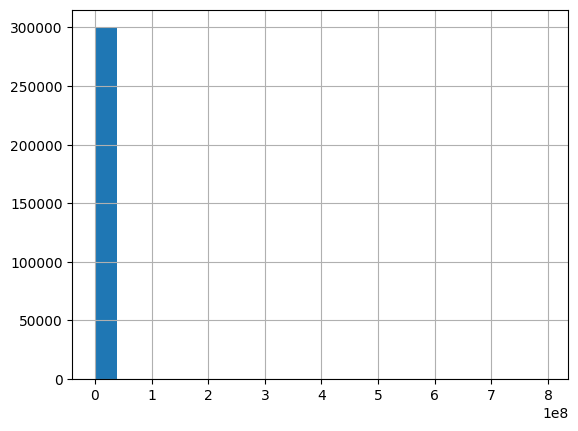

In [153]:
# построим гистограмму и посмотрим на распределение
data_sqft.hist(bins=20)

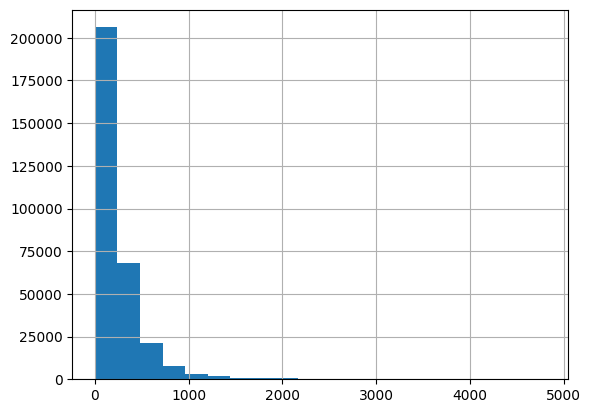

In [154]:
# уберем выбросы и посмотри снова на распределение
quant_095 = np.quantile(data_sqft , 0.95)
data_price_sqft[data_price_sqft < quant_095].hist(bins=20)
df['sqft'] = df['sqft'].apply(
    lambda x: x if x < quant_095  else np.nan
)

### Фича city

In [155]:
df['city'].value_counts()

Houston            24442
San Antonio        15592
Miami              15524
Jacksonville       10015
Dallas              8856
                   ...  
New Albany             1
Los Altos Hills        1
Lake worth             1
Lisle                  1
Blue Springs           1
Name: city, Length: 2026, dtype: int64

In [156]:
df['city'].value_counts()[0:250].sum()/df.shape[0]

0.8720972467091745

Всего в фиче город 2026 различных значений, это много. 250 первых занимают суммарно 87% данных. Можно их убрать, но хочу оставить их все.

## Предобработка baths

Популярные значения 1/2/3/4/2.5/5

In [157]:
df['baths'].value_counts()[0:10]

2 Baths         52466
3 Baths         35506
2               20452
2.0             16576
4 Baths         14764
3.0             10869
3               10113
Bathrooms: 2     9538
2.5              8113
Bathrooms: 3     6613
Name: baths, dtype: int64

In [158]:
# обработаем baths и уберем все лишнее
df['baths'] = df['baths'].replace(" Baths", "", regex=True)
df['baths'] = df['baths'].replace("Bathrooms: ", "", regex=True)
df['baths'] = df['baths'].replace(" ba", "", regex=True)

In [159]:
df['baths'] = df['baths'].apply(
        lambda x: int(2) if str(x) == '2.0' else x
)
df['baths'] = df['baths'].apply(
        lambda x: float(2) if str(x) == '2' else x
)

In [160]:
df['baths'] = df['baths'].apply(
        lambda x: int(3) if str(x) == '3.0' else x
)

In [161]:
df['baths'] = df['baths'].apply(
        lambda x: int(4) if str(x) == '4.0' else x
)
df['baths'] = df['baths'].apply(
        lambda x: float(4) if str(x) == '4' else x
)

In [162]:
df['baths'] = df['baths'].apply(
        lambda x: float(3) if str(x) == '3' else x
)

In [163]:
df['baths'] = df['baths'].apply(
        lambda x: int(1) if str(x) == '1.0' else x
)
df['baths'] = df['baths'].apply(
        lambda x: float(1) if str(x) == '1' else x
)
df['baths'] = df['baths'].apply(
        lambda x: float(5) if str(x) == '5' else x
)
df['baths'] = df['baths'].apply(
        lambda x: float(2.5) if str(x) == '2.5' else x
)

In [164]:
df.loc[(df['baths'] != 1.0) & (df['baths'] != 2.0)
    & (df['baths'] != 3.0) & (df['baths'] != 4.0) & (df['baths'] != 5.0)
     & (df['baths'] != 2.5)
      & (df['baths'].notna()), 'baths']  = -9999

In [165]:
df['baths'].value_counts()

 2.0       101718
 3.0        64994
-9999.0     41277
 4.0        26043
 1.0        16503
 2.5        12646
 5.0         7666
Name: baths, dtype: int64

## Предобработка status

In [166]:
# посмотрим уникальные значения
df['status'].value_counts()[0:20]

for sale                     156104
Active                       105207
For sale                      43465
foreclosure                    6426
New construction               5475
Pending                        4702
Pre-foreclosure                2119
Pre-foreclosure / auction      1560
P                              1488
Under Contract Show            1183
 / auction                      936
Under Contract   Showing        793
Active Under Contract           718
New                             690
Under Contract                  690
Contingent                      581
Price Change                    563
Auction                         536
Foreclosed                      459
A Active                        443
Name: status, dtype: int64

Выделю несколько значений фичи: for sale, active, foreclosure, new construction, pending, pre-foreclosure

In [167]:
df['status'] = df['status'].replace("For", "for", regex=True)

In [168]:
df['status'] = df['status'].apply(
        lambda x: "pre-oreclosure" if str(x).find('re-') >= 0 else x
)

In [169]:
df['status'] = df['status'].apply(
        lambda x: "foreclosure" if str(x).find('foreclos') >= 0 else x
)

In [170]:
df['status'] = df['status'].apply(
        lambda x: "active" if str(x).find('ctive') >= 0 else x
)

In [171]:
df.loc[(df['status'] != "for sale") & (df['status'] != "active")
    & (df['status'] != "foreclosure") & (df['status'] != "New construction")
    & (df['status'] != "pre-oreclosure") & (df['status'] != "Pending") 
      & (df['status'].notna()), 'status']  = 'other'

In [172]:
#удаляем дубликаты
duplicated = df.duplicated().sum()
df=df.drop_duplicates()

Посчитаем количество nan значений. Значения где target = nan нужно удалить, так как мы хотим чтобы был известен весь таргет.

In [173]:
pd.isnull(df).sum()[pd.isnull(df).sum() > 0]

status             38353
propertyType       30091
baths              98909
fireplace         263379
city                  31
sqft               83778
stories           141944
target              2394
Year built         54908
Remodeled year    215638
Heating            98445
Parking           181858
lotsize           104343
Price/sqft         73125
dtype: int64

In [174]:
df = df[df.target.notnull()]

## Предобработа таргета

In [175]:
# Удалим доллары и плюсы для дальнейшего анализа. 
df['target'] = df['target'].apply(
    lambda x: x[1:] if str(x).find('$') >= 0 else x
)
df['target'] = df['target'].apply(
    lambda x: x[:-1] if str(x).find('+') >= 0 else x
)

In [176]:
# Также удалим все запятые, и все символы кроме числовых. Преобразуем все в int.
df['target'] = df['target'].replace(',','', regex=True)
df['target'] = df['target'].str.extract('(\d+)', expand=False)
df['target']  = df['target'].astype('int')

<AxesSubplot: >

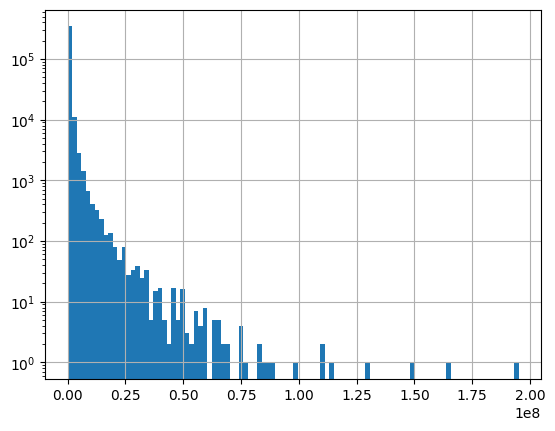

In [177]:
# Построим гистограмму как распределена цена на недвижимость
df['target'].hist(bins=100, log=True)

Видно что даже на логарифмической сетке присутсвует много выбросов

In [178]:
df['target'].describe()

count    3.635710e+05
mean     6.440387e+05
std      1.812025e+06
min      1.000000e+00
25%      1.900000e+05
50%      3.249000e+05
75%      5.849000e+05
max      1.950000e+08
Name: target, dtype: float64

Выбросом будем считать все что находится вне 95% и 0.35% квантильного диапазона. 0.35% подобрано из общих соображений, что 2000 минимальная граница суммы для аренды в США. 

In [179]:
quant_95 = np.quantile(df['target'], 0.95)
quant_95

1925000.0

In [180]:
quant_05 = np.quantile(df['target'], 0.0035)
quant_05

2000.0

In [181]:
df[(df['target'] >= quant_05) & (df['target'] <= quant_95)].shape

(344170, 18)

<AxesSubplot: >

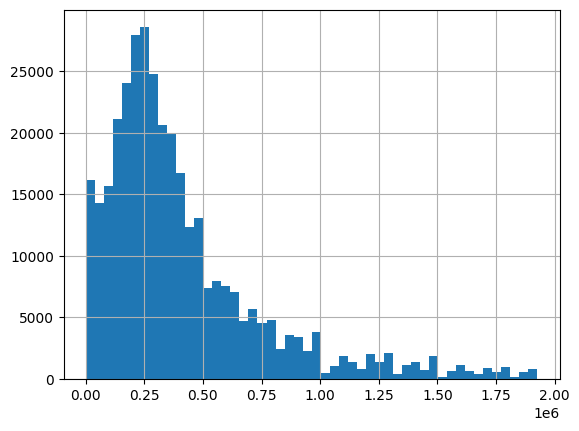

In [182]:
df[(df['target'] >= quant_05) & (df['target'] <= quant_95)]['target'].hist(bins=50)

In [183]:
# датасет который построен для дальнейшего анализа (обрезаем таргет по выбросам 
# и смотрим только те варианты где известно количество кроватей)
df_target_beds = df[(df['target'] >= quant_05) & (df['target'] <= quant_95) & (df['beds'] != -9999)]


# Анализ данных
## Зависимость цены от кол-ва кроватей

<AxesSubplot: >

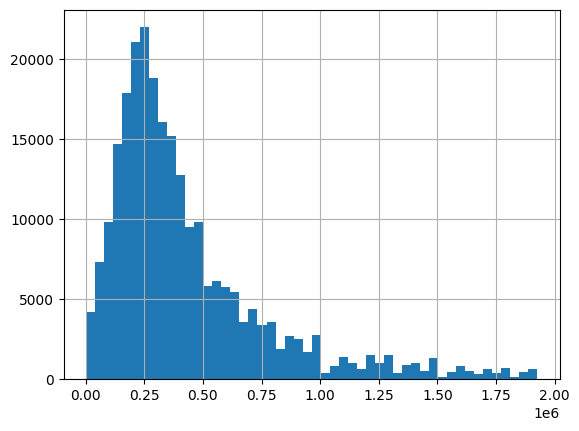

In [184]:
#Посмотрим график зависимости распределения цены от количества кроватей
df_target_beds['target'].hist(bins=50)

Видно, что после того как добавили фильтр на ограничение Nan по кроватям(-9999), распределение стало напоминать нормальное

In [185]:
df_target_beds.groupby(['beds']).agg({'target': ['sum', 'mean', 'count']})

c:\Users\админ\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:342: RuntimeWarning:

invalid value encountered in cast



target                      
               sum          mean   count
beds                                    
0     5.157429e+08  3.924984e+05    1314
1     1.925375e+09  3.191405e+05    6033
2     1.780020e+10  3.698743e+05   48125
3     3.718461e+10  3.691513e+05  100730
4     3.083916e+10  4.768770e+05   64669
5     1.222071e+10  6.680176e+05   18294
6     3.619497e+09  7.557939e+05    4789
7     9.729515e+08  8.337202e+05    1167
8     7.352634e+08  8.890730e+05     827
9     2.930790e+08  9.158718e+05     320
10    1.145281e+08  9.162246e+05     125
11    5.359666e+07  1.030705e+06      52
12    9.855055e+07  1.187356e+06      83

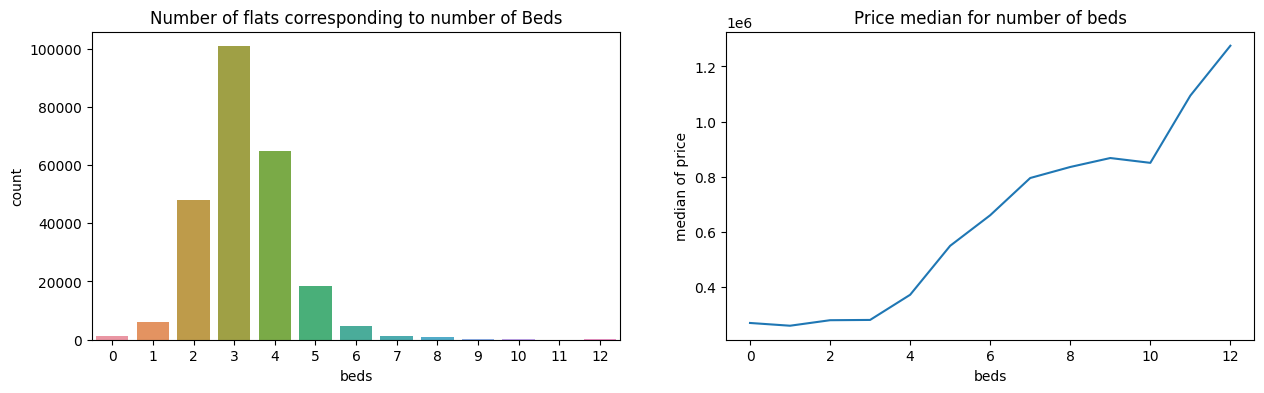

In [186]:
# посмотрим самую часто встречающуюся недвижимость и зависимоть медианной цены от кол-ва кроватей
median_for_num_bed = df_target_beds.groupby(['beds'])['target'].median()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))
countplot = sns.countplot(data = df_target_beds, x = 'beds', ax = axes[0])
countplot.set_title('Number of flats corresponding to number of Beds')
lineplot = sns.lineplot(data = median_for_num_bed, ax = axes[1])
lineplot.set_title('Price median for number of beds')
lineplot.set_ylabel('median of price');

Самые частотно встречающиеся недвижимость - недвижимость, где 2-4 кровати. Что логично. На правом графике построена медиана цены на недвижимость в зависимости от количества кроватей. Логично, что чем больше кроватей, тем больше медианная цена.

In [187]:
df.head(2)

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,PrivatePool,target,num_schools,Year built,Remodeled year,Heating,Parking,lotsize,Price/sqft
0,active,SF,-9999,gas,Southern Pines,2900.0,4,NC,NaN,0,418000,-9999,2019.0,NaN,pump,NaN,NaN,144.0
1,for sale,SF,3.0,NaN,Spokane Valley,1947.0,3,WA,2,0,310000,3,2019.0,NaN,NaN,NaN,0.13,159.0


## Зависимость стоимости недвижимости от района

Посмотрим как от района зависит стоимость недвижимости. Предположение - что есть районы (такие как Майами, где недвижимость дорогая). Буду рассматривать также датасет, где убраны Nan beds.

In [188]:
cnt_state = df_target_beds.groupby(['state'])['target'].count().reset_index()['target']

In [189]:
state = df_target_beds.groupby(['state'])['target'].count().reset_index()['state']

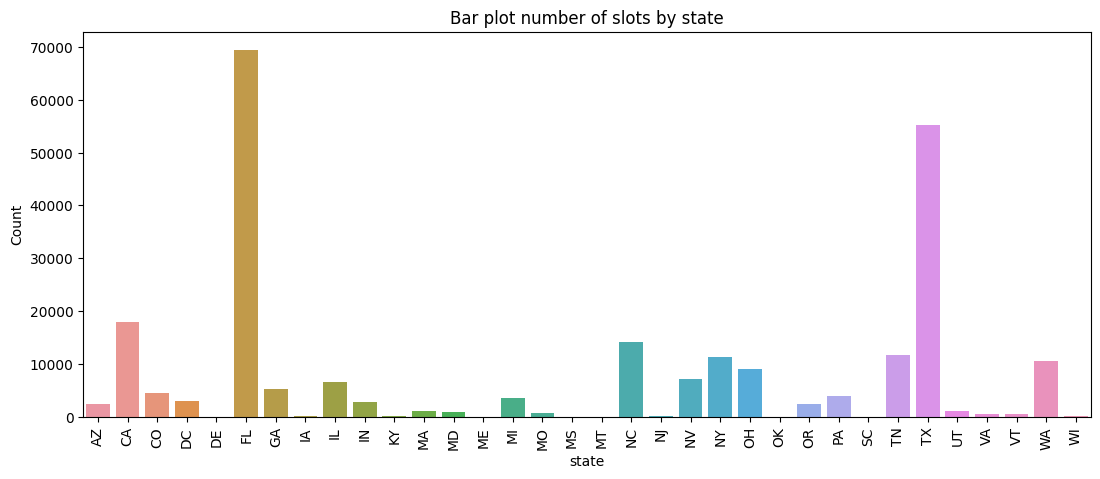

In [190]:
fig, ax = plt.subplots(figsize = (13, 5))
sns.barplot(x = state, y = cnt_state, ax = ax)
ax.set_title('Bar plot number of slots by state')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation = 90) 

Самые распространенный штаты по количеству предложений - Флорида и Техас. 


In [191]:
# посмотрим медианную цену
median_for_num_state = df_target_beds.groupby(['state'])['target'].median()

In [192]:
median_state = median_for_num_state.tolist()

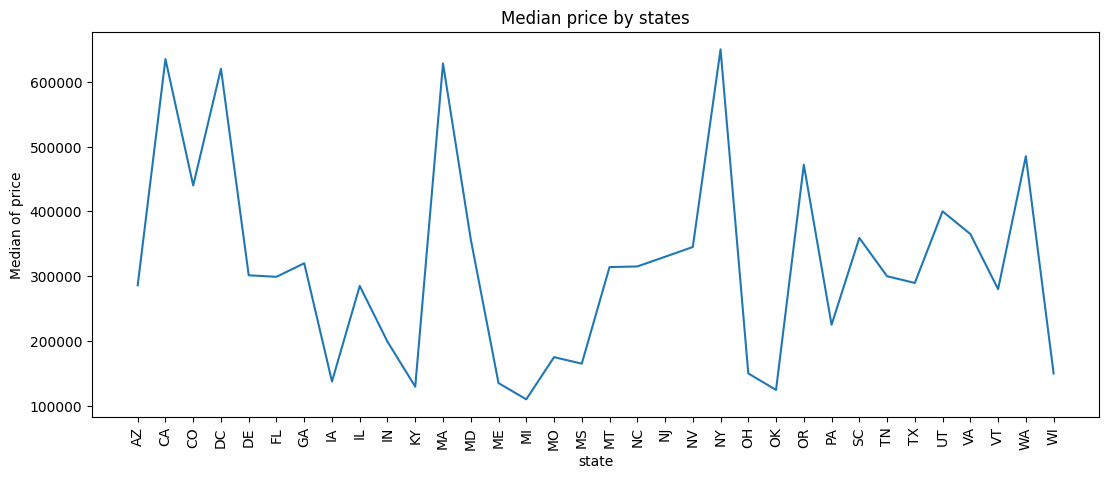

In [193]:
# построим линейный график зависимости медианной цены от штата
fig, ax = plt.subplots(figsize = (13, 5))
sns.lineplot(x = state, y = median_state, ax = ax)
ax.set_title('Median price by states')
ax.set_ylabel('Median of price')
ax.xaxis.set_tick_params(rotation = 90) 

Самая большая цена обнаружена в Калифорнии, Вашингтоне, Массачусетсе и Нью-Йорке.

## Нахождение самой высокой\низкой медианной стоимости недвижимости

Теперь давайте определим в каком городе самая высокая медианная стоимость недвижимости. И также посмотрим в каком самая низкая.


In [194]:
df_target_beds['city'].value_counts()[:500].sum()

234134

In [195]:
df_target_beds['city'].value_counts()[500:].sum()

12386

In [196]:
df_target_beds['city'].value_counts()[500:].sum()/df_target_beds['city'].value_counts()[:500].sum()

0.052901330007602484

In [197]:
df_target_beds['city'].value_counts()[:50]

Houston             14530
San Antonio         10488
Miami                9309
Jacksonville         6782
Chicago              5403
Dallas               5163
Las Vegas            5126
Orlando              4509
Charlotte            4329
Tampa                4193
Fort Worth           3451
Philadelphia         3393
Nashville            3142
Atlanta              3126
Cleveland            3030
Austin               3013
Washington           2942
Kissimmee            2791
Fort Lauderdale      2776
Brooklyn             2768
Los Angeles          2615
Seattle              2589
Ocala                2374
Indianapolis         2256
Saint Petersburg     2095
Denver               1892
Detroit              1817
Portland             1755
Palm Coast           1713
El Paso              1677
Raleigh              1504
Memphis              1439
Cincinnati           1433
Reno                 1405
San Diego            1385
Miami Beach          1298
Cape Coral           1292
Sacramento           1189
Fresno      

Санкт-Петербург явно лишний, но гугл говорит что это St. Petersburg, Florida, кто бы мог предположить..
Теперь надо пояснять в какой Санкт-Петербург едешь.

Буду рассматривать 500 городов, так как они покрывают 95% всех предложений. 

In [198]:
city = df_target_beds['city'].value_counts()[:500].reset_index()['city'].tolist()

In [166]:
df_city_median = df_target_beds.groupby(['city']).agg({'target': ['count', 'median']}).target.reset_index()

In [167]:
df_city_median.head()

,city,count,median
0,--,3,155900.0
1,ANN ARBOR,1,1169000.0
2,Abilene,132,219500.0
3,Abingdon,63,234900.0
4,Accokeek,3,349900.0


In [168]:
df_city_median[df_city_median['count']>= 50].sort_values(by = ['median'], ascending=False)[0:5]

,city,count,median
1348,Sherman Oaks,90,1367000.0
1433,Studio City,64,1349000.0
842,Long Island City,88,1300000.0
763,La Jolla,89,1299000.0
1294,San Francisco,490,1248000.0


Самая большая медиана на объекты недвижимости представлена в городе Sherman Oaks. Потом идут такие города как Studio City ,Long Island City.

Самая низкая медиана на объекты недвижмости представлена в городе Detroit. Что интересно, довольно много наблюдений ей соответсвует. Это говорит о низкой дисперсии.

In [169]:
df_target_beds.head(2)

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,PrivatePool,target,num_schools,Year built,Remodeled year,Heating,Parking,lotsize,Price/sqft
0,active,SF,-9999,gas,Southern Pines,2900.0,4,NC,NaN,0,418000,-9999,2019.0,NaN,pump,NaN,NaN,144.0
1,for sale,SF,3.0,NaN,Spokane Valley,1947.0,3,WA,2,0,310000,3,2019.0,NaN,NaN,NaN,0.13,159.0


## Влияние типа имущества на количество кроватей

Давайте посмотрим как влияет тип имущества на количество кроватей.

In [170]:
df_property_beds = df_target_beds.groupby(['propertyType', 'beds']).count()['target'].reset_index()

In [171]:
arr_SF_bed_04 = np.array(df_property_beds[df_property_beds['propertyType'] == 'SF'].target[0:5].tolist())/183356
arr_condo_bed_04 = np.array(df_property_beds[df_property_beds['propertyType'] == 'condo'].target[0:5].tolist())/40013
arr_townhouse_bed_04 = np.array(df_property_beds[df_property_beds['propertyType'] == 'townhouse'].target[0:5].tolist())/17299
arr_mobile_bed_04 = np.array(df_property_beds[df_property_beds['propertyType'] == 'mobile'].target[0:5].tolist())/3336
arr_lotland_bed_04 = np.array(df_property_beds[df_property_beds['propertyType'] == 'lot/land'].target[0:5].tolist())/2374
arr_coop_bed_04 = np.array(df_property_beds[df_property_beds['propertyType'] == 'coop'].target[0:5].tolist())/1833

In [172]:
x = np.arange(0, 5)

C:\Users\админ\AppData\Local\Temp\ipykernel_11592\820563593.py:2: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

C:\Users\админ\AppData\Local\Temp\ipykernel_11592\820563593.py:3: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

C:\Users\админ\AppData\Local\Temp\ipykernel_11592\820563593.py:4: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

C:\Users\админ\AppData\Local\Temp\ipykernel_11592\820563593.py:5: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

C:\Users\админ\AppData\Local\Temp\ipykernel_11592\820563593.py:6: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

C:\Users\админ\AppData\Local\Temp\ipykernel_11592\820563593.py:7: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



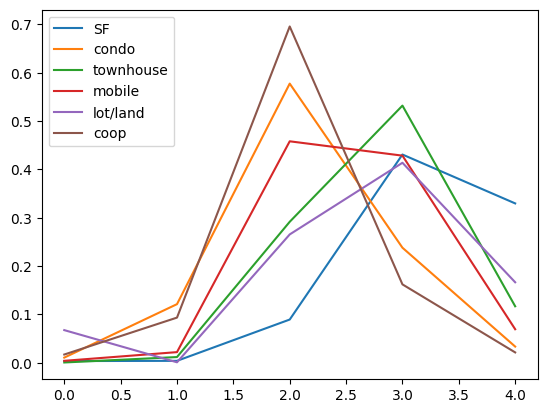

In [173]:
# построим линейные графики для иллюстрации как влияет тип недвижимости на кол-во кроватей
sns.lineplot(x = x, y = arr_SF_bed_04, palette = 'blue', label="SF")
sns.lineplot(x = x, y = arr_condo_bed_04, palette = 'orange', label="condo")
sns.lineplot(x = x, y = arr_townhouse_bed_04, palette = 'yellow', label="townhouse")
sns.lineplot(x = x, y = arr_mobile_bed_04, palette = 'green', label="mobile")
sns.lineplot(x = x, y = arr_lotland_bed_04, palette = 'brown', label="lot/land")
sns.lineplot(x = x, y = arr_coop_bed_04, palette = 'black', label="coop")
plt.legend()

Тут видна следующая картина: 2 кровати для coop встречаются чаще чем для condo, потом mobile, townhouse, lot/land, SF в относительном соотношении.
Для 4 картина уже другая: для SF относительное соотношение наибольшее, потом lot/land, townhouse, mobile, coop.

Отсюда можно сделать вывод, что для SF/townhouse больше используется 3 кровати, для coop/condo 2. 
И действительно, SF и townhouse по логике имеют большую площадь по сравнению с coop/condo.

In [174]:
df.head(2)

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,PrivatePool,target,num_schools,Year built,Remodeled year,Heating,Parking,lotsize,Price/sqft
0,active,SF,-9999,gas,Southern Pines,2900.0,4,NC,NaN,0,418000,-9999,2019.0,NaN,pump,NaN,NaN,144.0
1,for sale,SF,3.0,NaN,Spokane Valley,1947.0,3,WA,2,0,310000,3,2019.0,NaN,NaN,NaN,0.13,159.0


Давайте посмотрим как зависит Price/sqft от sqft

In [175]:
df['sqft']

0         2900.0
1         1947.0
2         3000.0
3            NaN
4            NaN
           ...  
377180    4017.0
377181    2000.0
377182    1152.0
377183       NaN
377184    1462.0
Name: sqft, Length: 363571, dtype: float64

In [176]:
sqft_price = df[['sqft', 'Price/sqft']].dropna()

In [177]:
np.corrcoef(sqft_price['sqft'] , sqft_price['Price/sqft'] )

array([[ 1.       , -0.0693817],
       [-0.0693817,  1.       ]])

 Корреляция не обнаружена

In [178]:
sqft_price[0:10000]

,sqft,Price/sqft
0,2900.0,144.0
1,1947.0,159.0
5,897.0,233.0
6,1507.0,120.0
8,3588.0,68.0
...,...,...
14375,1541.0,188.0
14376,2235.0,101.0
14377,1436.0,28.0
14378,1739.0,103.0


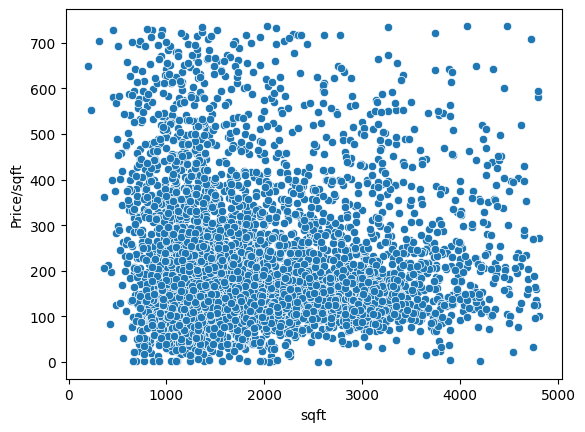

In [179]:
# посмотрим как зависит Price/sqft от sqft
sns.scatterplot(data=sqft_price[0:5000], x='sqft', y='Price/sqft');

Из графика также видно что линейной связи нет

# Предобработка всего датасета

In [180]:
df.head(3)

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,PrivatePool,target,num_schools,Year built,Remodeled year,Heating,Parking,lotsize,Price/sqft
0,active,SF,-9999,gas,Southern Pines,2900.0,4,NC,NaN,0,418000,-9999,2019.0,NaN,pump,NaN,NaN,144.0
1,for sale,SF,3.0,NaN,Spokane Valley,1947.0,3,WA,2,0,310000,3,2019.0,NaN,NaN,NaN,0.13,159.0
2,for sale,SF,2.0,1,Los Angeles,3000.0,3,CA,1,1,2895000,3,1961.0,1967.0,Forced air,Attached Garage,0.20,NaN


In [181]:
df['stories'].value_counts()

 1       100927
 2        81232
 3        16814
 0        11443
-9999      7007
 4         3204
 6         1011
 5          827
Name: stories, dtype: int64

In [182]:
df.columns

Index(['status', 'propertyType', 'baths', 'fireplace', 'city', 'sqft', 'beds',
       'state', 'stories', 'PrivatePool', 'target', 'num_schools',
       'Year built', 'Remodeled year', 'Heating', 'Parking', 'lotsize',
       'Price/sqft'],
      dtype='object')

In [183]:
df['lotsize'].max()

2.65

In [184]:
y = df['target'] # выделение целевой переменной
df_train = df.drop(['target'], axis=1) # дроп целевой из таргета

In [185]:
df_train['status'] = df_train['status'].fillna("NAN")

In [186]:
df_train['Heating'].value_counts()

Forced air    132532
Other          52737
electric       28425
Gas            21396
Central        18716
pump           11901
Name: Heating, dtype: int64

In [187]:
df_train['Heating']

0               pump
1                NaN
2         Forced air
3         Forced air
4                NaN
             ...    
377180         Other
377181         Other
377182         Other
377183         Other
377184      electric
Name: Heating, Length: 363571, dtype: object

In [188]:
df_train['propertyType'] = df_train['propertyType'].fillna("NAN")
df_train['fireplace'] = df_train['fireplace'].fillna("NAN")
df_train['city'] = df_train['city'].fillna("NAN")

In [189]:
df_train['stories'] = df_train['stories'].fillna("-10")

In [190]:
df_train['Heating'] = df_train['Heating'].fillna("NAN")

In [191]:
df_train['Parking'] = df_train['Parking'].fillna("NAN")

In [192]:
df_train['baths'] = df_train['baths'].apply(
        lambda x: float(-10.0) if str(x) == 'other' else x
)

In [193]:
df_train['stories'] = df_train['stories'].apply(
        lambda x: int(-9999) if str(x) == 'Other' else x
)

In [194]:
df_train['stories'] = df['stories'].apply(
    lambda x: int(-10) if x == 'NaN'  else x
)

In [195]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363571 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          363571 non-null  object 
 1   propertyType    363571 non-null  object 
 2   baths           265541 non-null  float64
 3   fireplace       363571 non-null  object 
 4   city            363571 non-null  object 
 5   sqft            280545 non-null  float64
 6   beds            363571 non-null  int64  
 7   state           363571 non-null  object 
 8   stories         222465 non-null  float64
 9   PrivatePool     363571 non-null  int64  
 10  num_schools     363571 non-null  int64  
 11  Year built      308911 non-null  float64
 12  Remodeled year  149091 non-null  float64
 13  Heating         363571 non-null  object 
 14  Parking         363571 non-null  object 
 15  lotsize         259687 non-null  float64
 16  Price/sqft      292504 non-null  float64
dtypes: float64

In [196]:
df_train['stories'] = df_train['stories'].fillna("-10")

In [197]:
df_train['stories'] = df_train['stories'].astype('int')

In [198]:
#разделим нашим данные на train и test
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=42)

In [199]:
# категориальные признаки
cat_features = ['status', 'propertyType', 'fireplace', 'city', 'state', 'stories', 'Heating', 'Parking']

In [200]:
train_pool = Pool(X_train, y_train, cat_features=cat_features) # создание пула для дальнейшей работы
test_pool = Pool(X_test, y_test, cat_features=cat_features) # тест для дальнейшей проверки метрик

In [201]:
from catboost import CatBoostRegressor

In [202]:
# построим модель 
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(train_pool, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1752197.6073287	total: 477ms	remaining: 2m 22s
1:	learn: 1700966.1648238	total: 865ms	remaining: 2m 8s
2:	learn: 1661353.9189069	total: 1.22s	remaining: 2m
3:	learn: 1624251.4785105	total: 1.5s	remaining: 1m 51s
4:	learn: 1593742.2507784	total: 1.82s	remaining: 1m 47s
5:	learn: 1568185.7504399	total: 2.12s	remaining: 1m 43s
6:	learn: 1546975.8304409	total: 2.4s	remaining: 1m 40s
7:	learn: 1523135.0698785	total: 2.71s	remaining: 1m 39s
8:	learn: 1503861.6480716	total: 3.02s	remaining: 1m 37s
9:	learn: 1486331.2868171	total: 3.3s	remaining: 1m 35s
10:	learn: 1470529.8960754	total: 3.63s	remaining: 1m 35s
11:	learn: 1456875.1666217	total: 3.9s	remaining: 1m 33s
12:	learn: 1446547.6807178	total: 4.17s	remaining: 1m 31s
13:	learn: 1437057.7111118	total: 4.48s	remaining: 1m 31s
14:	learn: 1425918.9251290	total: 4.77s	remaining: 1m 30s
15:	learn: 1416580.9215009	total: 5.06s	remaining: 1m 29s
16:	learn: 1408702.2135695	total: 5.39s	remaining: 1m 29s
17:	learn: 1401017.9970051	total:

23:	learn: 1366424.8852264	total: 7.68s	remaining: 1m 28s
24:	learn: 1362746.3332913	total: 8.04s	remaining: 1m 28s
25:	learn: 1358496.0911078	total: 8.45s	remaining: 1m 29s
26:	learn: 1355154.4370242	total: 8.86s	remaining: 1m 29s
27:	learn: 1350237.6552958	total: 9.18s	remaining: 1m 29s
28:	learn: 1345957.4888376	total: 9.52s	remaining: 1m 29s
29:	learn: 1342497.3992430	total: 9.83s	remaining: 1m 28s
30:	learn: 1339409.2108336	total: 10.1s	remaining: 1m 28s
31:	learn: 1336323.7415023	total: 10.5s	remaining: 1m 27s
32:	learn: 1332490.0324887	total: 10.8s	remaining: 1m 27s
33:	learn: 1330095.8332451	total: 11.1s	remaining: 1m 26s
34:	learn: 1327666.3232917	total: 11.4s	remaining: 1m 25s
35:	learn: 1325498.8626597	total: 11.7s	remaining: 1m 25s
36:	learn: 1323430.4953069	total: 12s	remaining: 1m 25s
37:	learn: 1321274.5011400	total: 12.3s	remaining: 1m 24s
38:	learn: 1319055.9158339	total: 12.6s	remaining: 1m 24s
39:	learn: 1315989.7159407	total: 12.9s	remaining: 1m 24s
40:	learn: 13121

Значение метрики RMSE вышло на плато

In [203]:
model.get_feature_importance()

array([ 1.38934359,  6.02981338,  6.67397509,  0.89361965, 18.19700242,
       13.04720586, 17.3209354 ,  0.94850779,  0.64423319,  5.18281386,
        0.33689068,  1.80335272,  0.615497  ,  0.79849645,  0.39701443,
        5.81363889, 19.9076596 ])

Text(0.5, 1.0, 'Feature Importance')

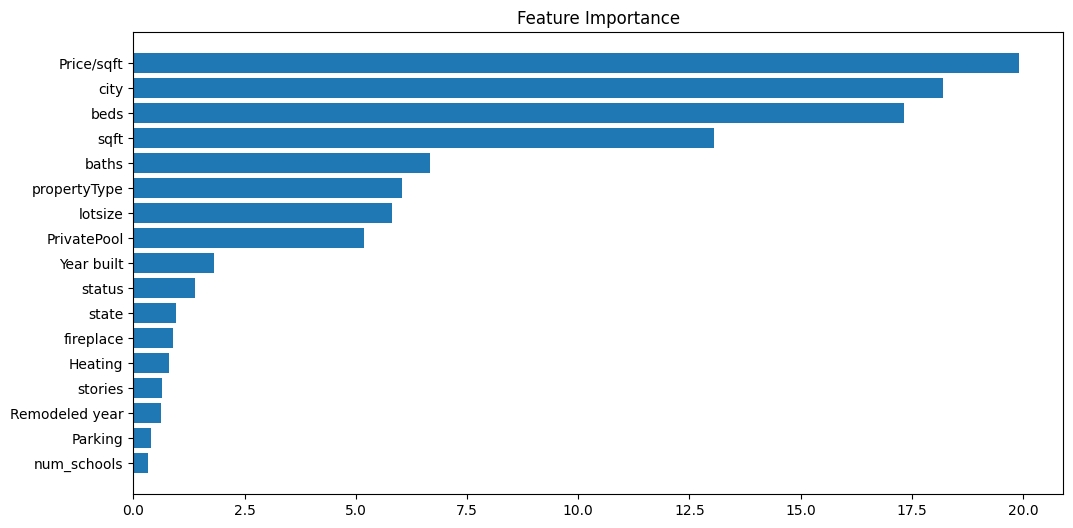

In [204]:
# посмотрим на наиболее важные признаки
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Посмотрим есть ли корреляция между  Price\sqft и target.


In [205]:
df1 = df.copy()

In [206]:
df1['target'] = y

In [207]:
sqft_target = df1[['Price/sqft', 'target']].dropna()

In [208]:
beds_target = df1[['beds', 'target']].dropna()

In [209]:
np.corrcoef(sqft_target['target'] , sqft_target['Price/sqft'] )

array([[1.        , 0.55177204],
       [0.55177204, 1.        ]])

Корреляция между фичами 55%. Это очень сильньно коррелированные величины, поэтому удалю Price/sqft из дальнейшего анализа.

In [210]:
np.corrcoef(beds_target['target'] , beds_target['beds'] )

array([[1.        , 0.01002924],
       [0.01002924, 1.        ]])

Переобучим модель без фичи Price/sqft

In [211]:
df_train = df_train.drop(['Price/sqft'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=42)
train_pool = Pool(X_train, y_train, cat_features=cat_features) # создание пула для дальнейшей работы
test_pool = Pool(X_test, y_test, cat_features=cat_features)


In [212]:
#обучаем модель
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(train_pool, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1765073.6516695	total: 285ms	remaining: 1m 25s
1:	learn: 1729863.9351584	total: 646ms	remaining: 1m 36s
2:	learn: 1687857.3127839	total: 1.03s	remaining: 1m 41s
3:	learn: 1657776.7968688	total: 1.32s	remaining: 1m 37s
4:	learn: 1626763.3822038	total: 1.64s	remaining: 1m 36s
5:	learn: 1601707.6779300	total: 1.92s	remaining: 1m 33s
6:	learn: 1582711.5994107	total: 2.13s	remaining: 1m 29s
7:	learn: 1566540.9100758	total: 2.42s	remaining: 1m 28s
8:	learn: 1550436.8445502	total: 2.69s	remaining: 1m 26s
9:	learn: 1536751.9704881	total: 2.96s	remaining: 1m 25s
10:	learn: 1523807.7257196	total: 3.24s	remaining: 1m 25s
11:	learn: 1513752.2202706	total: 3.45s	remaining: 1m 22s
12:	learn: 1504060.4277087	total: 3.8s	remaining: 1m 23s
13:	learn: 1495535.4831982	total: 4.09s	remaining: 1m 23s
14:	learn: 1486941.7098654	total: 4.43s	remaining: 1m 24s
15:	learn: 1479604.4060197	total: 4.73s	remaining: 1m 24s
16:	learn: 1473395.7664955	total: 5.07s	remaining: 1m 24s
17:	learn: 1466425.891219

Text(0.5, 1.0, 'Feature Importance')

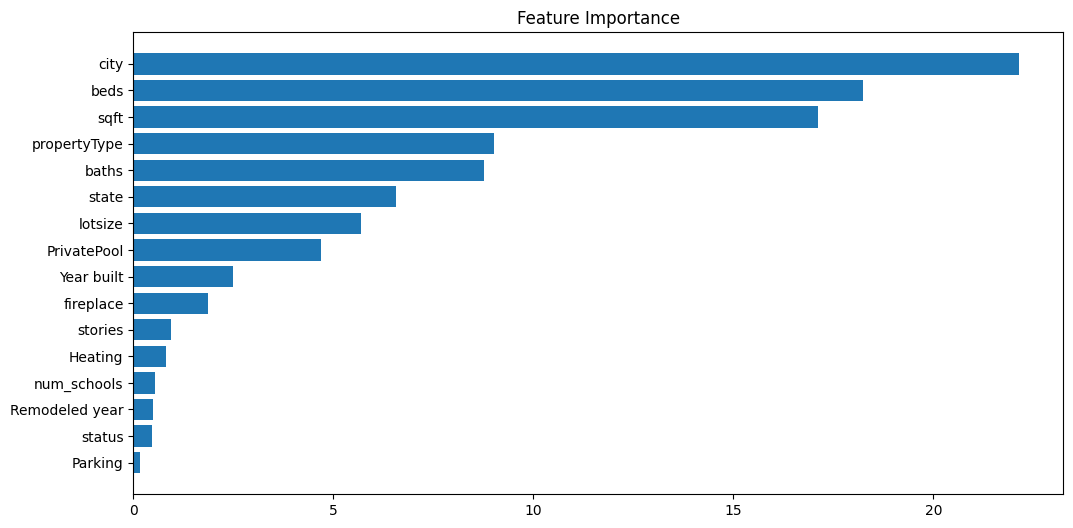

In [213]:
# посмотрим на наиболее важные признаки
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Топ 5 фичей по убыванию: 
  * city
  * beds
  * sqft
  * propertyType
  * baths

In [214]:
# запись в файл 
import pickle
pickle.dump(model, open('model_final.pkl', 'wb'))

In [215]:
#загружаем объект из файла
model_test = pickle.load(open("model_final.pkl", "rb"))

In [216]:
model_test.feature_importances_

array([ 0.4555433 ,  9.01089203,  8.76194904,  1.8753591 , 22.14002488,
       17.10700673, 18.23930895,  6.57101891,  0.9383691 ,  4.69579195,
        0.5446039 ,  2.48273688,  0.48806241,  0.82095326,  0.17086696,
        5.6975126 ])

In [217]:
df.columns

Index(['status', 'propertyType', 'baths', 'fireplace', 'city', 'sqft', 'beds',
       'state', 'stories', 'PrivatePool', 'target', 'num_schools',
       'Year built', 'Remodeled year', 'Heating', 'Parking', 'lotsize',
       'Price/sqft'],
      dtype='object')